In [1]:
import os, sys, psutil

import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

from tqdm.notebook import tqdm as tq
import itertools

from IPython.display import clear_output
import warnings; warnings.simplefilter('ignore')

# Helper functions

In [2]:
def mapp(func, *iterables, cb=None, **kwargs):
    """map function that uses tq for progress bar"""
    for i in tq(range(len(iterables[0]))):
        res = func(*[iterable[i] for iterable in iterables], **kwargs)
        if cb is not None:
            cb(res)
        yield res

def imshow(a, figsize=(8,6), cmap='seismic', **pltargs):
    """Uses magic to create pretty images from arrays."""

    if sp.issparse(a):
        a = a.todense()
    else:
        a = np.array(a, copy=False)
    if np.prod(a.shape) == np.max(a.shape):
        a = a.flatten()
    fig = plt.figure(figsize=figsize)
    cmap = plt.get_cmap(cmap)
    if 'vmin' not in pltargs and 'vmax' not in pltargs:
        vmax = np.max(np.abs(a))
        vmin = -vmax
    plt.imshow(a, cmap=cmap, vmin=vmin, vmax=vmax, **pltargs)
    plt.colorbar()

def hist(data, bins=None, xlabel="", title="", density=False):
    def bins_sqrt(data):
        return int(np.ceil(np.sqrt(len(data))))

    plt.figure(figsize=(10,5))

    # bins
    if not bins:
        bins = bins_sqrt(data)
    n, bins, _ = plt.hist(data, bins=bins, density=density)

    # visuals
    plt.title(title)
    plt.ylabel("Density" if density else "Frequency")
    plt.xlabel(xlabel)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    return n, bins

def scatter1d(data, xticks=None, alpha=.5, s=500, marker="|", xlim=None, title="", **pltargs):
    """Create only one axis on which to plot the data."""

    fig = plt.figure(figsize=(10,1))
    ax = fig.gca()
    size = np.array(data, copy=False).flatten().shape
    plt.scatter(data, np.zeros(*size), alpha=alpha, marker=marker, s=s, **pltargs)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    if xticks:
        ax.set_xticks(xticks)
    if title:
        ax.set_title(title)
    if xlim is not None:
        ax.set_xlim(xlim)
    fig.tight_layout()
    plt.show()

def duh(n, precision=2):
    """ Takes a number of bytes and returns a human-readable string with the
    size in bytes, kilobytes, megabytes, or gigabytes.

    Parameters
        n (int): The number of bytes
        precision (int): The number of decimals to use
    """
    for unit in ['B','KB','MB','GB','TB','PB','EB','ZB']:
        if n < 1024.0:
            break
        n /= 1024.0
    decimals = precision - int(n > 99) - int(n > 9) - int(n > 0)
    if decimals < 0 or unit == 'B':
        decimals = 0
    return f"{n:.{decimals}f} {unit}"

def ising_model(n_qubits, J, h=None, g=None, offset=0, kind='1d', circular=False):
    """
    Generates an Ising model with (optional) longitudinal and (optional) transverse couplings.

    Parameters
    ----------
    n_qubits : int or tuple
        Number of qubits, at least 2. For `kind='2d'` or `kind='3d'`, give a tuple of 2 or 3 integers, respectively.
    J : float, array, or dict
        Coupling strength. If a scalar, all couplings are set to this value.
        If a 2-element vector but `n_qubit > 2` (or tuple), all couplings are set to a random value in this range.
        If a matrix, this matrix is used as the coupling matrix.
        For `kind='pairwise'`, `kind='2d'`, or `kind='3d'`, `J` is read as an incidence matrix, where the rows and columns correspond to the qubits and the values are the coupling strengths. Only the upper triangular part of the matrix is used.
        For `kind='full'`, specify a dictionary with keys being tuples of qubit indices and values being the corresponding coupling strength.
    h : float or array, optional
        Longitudinal field strength. If a scalar, all fields are set to this value.
        If a 2-element vector, all fields are set to a random value in this range.
        If a vector of size `n_qubits`, its elements specify the individual strengths of the longitudinal field.
    g : float or array, optional
        Transverse field strength. If a scalar, all couplings are set to this value.
        If a 2-element vector, all couplings are set to a random value in this range.
        If a vector of size `n_qubits`, its elements specify the individual strengths of the transverse field.
    offset : float, optional
        Offset of the Hamiltonian.
    kind : {'1d', '2d', '3d', 'pairwise', 'full'}, optional
        Whether the couplings are along a string (`1d`), on a 2d-lattice (`2d`), 3d-lattice (`3d`), fully connected graph (`pairwise`), or specify the desired multi-particle interactions.
    circular : bool, optional
        Whether the couplings are circular (i.e. the outermost qubits are coupled to each other). Only applies to `kind='1d'`, `kind='2d'`, and `kind='3d'`.

    Returns
    -------
    H : str
        The Hamiltonian as a string, which can be parsed by parse_hamiltonian.
    """

    # generate the coupling shape
    n_total_qubits = np.prod(n_qubits)
    assert n_total_qubits - int(n_total_qubits) == 0, "n_qubits must be an integer or a tuple of integers"
    if kind == '1d':
        assert np.isscalar(n_qubits) or len(n_qubits) == 1, f"For kind={kind}, n_qubits must be an integer or tuple of length 1, but is {n_qubits}"
        # convert to int if tuple (has attr __len__)
        if hasattr(n_qubits, '__len__'):
            n_qubits = n_qubits[0]
        couplings = (n_qubits if circular and n_qubits > 2 else n_qubits-1,)
    elif kind == '2d':
        if np.isscalar(n_qubits) or len(n_qubits) == 1:
            raise ValueError(f"For kind={kind}, n_qubits must be a tuple of length 2, but is {n_qubits}")
        couplings = (n_total_qubits, n_total_qubits)
    elif kind == '3d':
        if np.isscalar(n_qubits) or len(n_qubits) == 2:
            raise ValueError(f"For kind={kind}, n_qubits must be a tuple of length 3, but is {n_qubits}")
        couplings = (n_total_qubits, n_total_qubits)
    elif kind == 'pairwise':
        assert type(n_qubits) == int, f"For kind={kind}, n_qubits must be an integer, but is {n_qubits}"
        couplings = (n_qubits, n_qubits)
    elif kind == 'full':
        assert type(n_qubits) == int, f"For kind={kind}, n_qubits must be an integer, but is {n_qubits}"
        couplings = (2**n_qubits,)
    else:
        raise ValueError(f"Unknown kind {kind}")

    # if J is not scalar or dict, it must be either the array of the couplings or the limits of the random range
    if not (np.isscalar(J) or isinstance(J, dict)):
        J = np.array(J)
        if J.shape == (2,):
            J = np.random.uniform(J[0], J[1], couplings)
        if kind == '1d' and J.shape == (n_qubits, n_qubits):
            # get the offset k=1 diagonal (n_quibits-1 elements)
            idxs = np.where(np.eye(n_qubits, k=1))
            if circular:
                # add the edge element
                idxs = (np.append(idxs[0], 0), np.append(idxs[1], n_qubits-1))
            J = J[idxs]
        assert J.shape == couplings, f"For kind={kind}, J must be a scalar, 2-element vector, or matrix of shape {couplings}, but is {J.shape}"
    elif isinstance(J, dict) and kind != 'full':
        raise ValueError(f"For kind={kind}, J must not be a dict!")

    if h is not None:
        if n_total_qubits != 2 and hasattr(h, '__len__') and len(h) == 2:
            h = np.random.uniform(low=h[0], high=h[1], size=n_total_qubits)
        elif not np.isscalar(h):
            h = np.array(h)
        assert np.isscalar(h) or h.shape == (n_total_qubits,), f"h must be a scalar, 2-element vector, or vector of shape {(n_total_qubits,)}, but is {h.shape if not np.isscalar(h) else h}"
    if g is not None:
        if n_total_qubits != 2 and hasattr(g, '__len__') and len(g) == 2:
            g = np.random.uniform(low=g[0], high=g[1], size=n_total_qubits)
        elif not np.isscalar(g):
            g = np.array(g)
        assert np.isscalar(g) or g.shape == (n_total_qubits,), f"g must be a scalar, 2-element vector, or vector of shape {(n_total_qubits,)}, but is {g.shape if not np.isscalar(g) else g}"

    # generate the Hamiltonian
    H_str = ''
    # pairwise interactions
    if kind == '1d':
        if np.isscalar(J):
            for i in range(n_qubits-1):
                H_str += 'I'*i + 'ZZ' + 'I'*(n_qubits-i-2) + ' + '
            # last and first qubit
            if circular:
                H_str += 'Z' + 'I'*(n_qubits-2) + 'Z' + ' + '
        else:
            for i in range(n_qubits-1):
                if J[i] != 0:
                    H_str += str(J[i]) + '*' + 'I'*i + 'ZZ' + 'I'*(n_qubits-i-2) + ' + '
            # last and first qubit
            if circular and J[n_qubits-1] != 0:
                H_str += str(J[n_qubits-1]) + '*' + 'Z' + 'I'*(n_qubits-2) + 'Z' + ' + '
    elif kind == '2d':
        for i in range(n_qubits[0]):
            for j in range(n_qubits[1]):
                # find all 2d neighbors, but avoid double counting
                neighbors = []
                if i > 0:
                    neighbors.append((i-1, j))
                if i < n_qubits[0]-1:
                    neighbors.append((i+1, j))
                if j > 0:
                    neighbors.append((i, j-1))
                if j < n_qubits[1]-1:
                    neighbors.append((i, j+1))
                if circular:
                    if i == n_qubits[0]-1 and n_qubits[0] > 2:
                        neighbors.append((0, j))
                    if j == n_qubits[1]-1 and n_qubits[1] > 2:
                        neighbors.append((i, 0))
                # add interactions
                index_node = i*n_qubits[1] + j
                for neighbor in neighbors:
                    # 1. lower row
                    # 2. same row, but further to the right or row circular (= first column and j is last column)
                    # 3. same column, but column circular (= first row and i is last row)
                    if neighbor[0] > i \
                        or (neighbor[0] == i and (neighbor[1] > j or (j == n_qubits[1]-1 and neighbor[1] == 0 and n_qubits[1] > 2))) \
                        or (neighbor[1] == j and i == n_qubits[0]-1 and neighbor[0] == 0 and n_qubits[0] > 2):
                        index_neighbor = neighbor[0]*n_qubits[1] + neighbor[1]
                        first_index = min(index_node, index_neighbor)
                        second_index = max(index_node, index_neighbor)
                        if not np.isscalar(J):
                            if J[first_index, second_index] == 0:
                                continue
                            H_str += str(J[first_index, second_index]) + '*'
                        H_str += 'I'*first_index + 'Z' + 'I'*(second_index-first_index-1) + 'Z' + 'I'*(n_qubits[0]*n_qubits[1]-second_index-1) + ' + '
    elif kind == '3d':
        for i in range(n_qubits[0]):
            for j in range(n_qubits[1]):
                for k in range(n_qubits[2]):
                    # find all 3d neighbors, but avoid double counting
                    neighbors = []
                    if i > 0:
                        neighbors.append((i-1, j, k))
                    if i < n_qubits[0]-1:
                        neighbors.append((i+1, j, k))
                    if j > 0:
                        neighbors.append((i, j-1, k))
                    if j < n_qubits[1]-1:
                        neighbors.append((i, j+1, k))
                    if k > 0:
                        neighbors.append((i, j, k-1))
                    if k < n_qubits[2]-1:
                        neighbors.append((i, j, k+1))
                    if circular:
                        if i == n_qubits[0]-1 and n_qubits[0] > 2:
                            neighbors.append((0, j, k))
                        if j == n_qubits[1]-1 and n_qubits[1] > 2:
                            neighbors.append((i, 0, k))
                        if k == n_qubits[2]-1 and n_qubits[2] > 2:
                            neighbors.append((i, j, 0))
                    # add interactions
                    index_node = i*n_qubits[1]*n_qubits[2] + j*n_qubits[2] + k
                    for neighbor in neighbors:
                        # 1. lower row
                        # 2. same row, but
                            # a. same layer, but further to the right or row circular (= first column and j is last column)
                            # b. same column, but further behind or layer circular (= first layer and k is last layer)
                        # 3. same column and same layer, but column circular (= first row and i is last row)
                        if neighbor[0] > i \
                            or (neighbor[0] == i and (\
                                (neighbor[2] == k and (neighbor[1] > j or (j == n_qubits[1]-1 and neighbor[1] == 0 and n_qubits[1] > 2))) \
                                or (neighbor[1] == j and (neighbor[2] > k or (k == n_qubits[2]-1 and neighbor[2] == 0 and n_qubits[2] > 2))) \
                            )) \
                            or (neighbor[1] == j and neighbor[2] == k and i == n_qubits[0]-1 and neighbor[0] == 0 and n_qubits[0] > 2):
                            index_neighbor = neighbor[0]*n_qubits[1]*n_qubits[2] + neighbor[1]*n_qubits[2] + neighbor[2]
                            first_index = min(index_node, index_neighbor)
                            second_index = max(index_node, index_neighbor)
                            if not np.isscalar(J):
                                if J[first_index, second_index] == 0:
                                    continue
                                H_str += str(J[first_index, second_index]) + '*' 
                            H_str += 'I'*first_index + 'Z' + 'I'*(second_index-first_index-1) + 'Z' + 'I'*(n_qubits[0]*n_qubits[1]*n_qubits[2]-second_index-1) + ' + '
    elif kind == 'pairwise':
        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                if not np.isscalar(J):
                    if J[i,j] == 0:
                        continue
                    H_str += str(J[i,j]) + '*'
                H_str += 'I'*i + 'Z' + 'I'*(j-i-1) + 'Z' + 'I'*(n_qubits-j-1) + ' + '
    elif kind == 'full':
        if np.isscalar(J):
            if n_qubits > 20:
                raise ValueError("Printing out all interactions for n_qubits > 20 is not recommended. Please use a dict instead.")
            for i in range(2, n_qubits+1):
                for membership in itertools.combinations(range(n_qubits), i):
                    H_str += ''.join(['Z' if j in membership else 'I' for j in range(n_qubits)]) + ' + '
        else: # J is a dict of tuples of qubit indices to interaction strengths
            for membership, strength in J.items():
                if strength == 0:
                    continue
                H_str += str(strength) + '*' + ''.join(['Z' if j in membership else 'I' for j in range(n_qubits)]) + ' + '
    else:
        raise ValueError(f"Unknown kind {kind}")

    if np.isscalar(J) and J != 0 and n_total_qubits > 1:
        H_str = str(J) + '*(' + H_str[:-3] + ') + '

    # local longitudinal fields
    if np.any(h):
        if np.isscalar(h):
            H_str += str(h) + '*(' + ' + '.join(['I'*i + 'Z' + 'I'*(n_total_qubits-i-1) for i in range(n_total_qubits)]) + ') + '
        else:
            H_str += ' + '.join([str(h[i]) + '*' + 'I'*i + 'Z' + 'I'*(n_total_qubits-i-1) for i in range(n_total_qubits) if h[i] != 0]) + ' + '
    # local transverse fields
    if np.any(g):
        if np.isscalar(g):
            H_str += str(g) + '*(' + ' + '.join(['I'*i + 'X' + 'I'*(n_total_qubits-i-1) for i in range(n_total_qubits)]) + ') + '
        else:
            H_str += ' + '.join([str(g[i]) + '*' + 'I'*i + 'X' + 'I'*(n_total_qubits-i-1) for i in range(n_total_qubits) if g[i] != 0]) + ' + '
    # offset
    if np.any(offset):
        H_str += str(offset)
    else:
        H_str = H_str[:-3]
    return H_str

def parse_hamiltonian(hamiltonian, sparse=False):
    """Parse a string representation of a Hamiltonian into a matrix representation. The result is guaranteed to be Hermitian.

    Example:
    >>> parse_hamiltonian('0.5*(XX + YY + ZZ + II)') # SWAP
    array([[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
           [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]])
    >>> parse_hamiltonian('-(XX + YY + .5*ZZ) + 1.5')
    array([[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
           [ 0.+0.j  2.+0.j -2.+0.j  0.+0.j]
           [ 0.+0.j -2.+0.j  2.+0.j  0.+0.j]
           [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]])
    >>> parse_hamiltonian('0.5*(II + ZI - ZX + IX)') # CNOT

    """
    def s(gate):
        if gate == "H":
            gate_matrix = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
        elif gate == "X":
            gate_matrix = np.array([[0, 1], [1, 0]])
        elif gate == "Y":
            gate_matrix = np.array([[0, -1j], [1j, 0]])
        elif gate == "Z":
            gate_matrix = np.array([[1, 0], [0, -1]])
        elif gate == "I":
            gate_matrix = np.eye(2)
        else:
            raise ValueError(f"Unknown gate {gate}")
        return gate_matrix if not sparse else sp.bsr_array(gate_matrix)

    # Remove whitespace
    hamiltonian = hamiltonian.replace(" ", "")
    # replace - with +-, except before e
    hamiltonian = hamiltonian \
                    .replace("-", "+-") \
                    .replace("e+-", "e-") \
                    .replace("(+-", "(-")

    # Find parts in parentheses
    part = ""
    parts = []
    depth = 0
    for c in hamiltonian:
        if c == "(":
            depth += 1
        elif c == ")":
            depth -= 1
        if depth > 0:
            part += c
        if depth == 0 and c == ")":
            part += c
            # reject parts with complex numbers
            try:
                assert complex(part).imag == 0, "Complex coefficients lead to non-hermitian matrices"
            except ValueError:
                pass
            parts.append(part)
            part = ""

    # Replace parts in parentheses with a placeholder
    for i, part in enumerate(parts):
        hamiltonian = hamiltonian.replace(part, f"part{i}", 1)
        # Calculate the part recursively
        parts[i] = parse_hamiltonian(part[1:-1], sparse=sparse)

    # Parse the rest of the Hamiltonian
    chunks = hamiltonian.split("+")
    # Remove empty chunks
    chunks = [c for c in chunks if c != ""]
    # If parts are present, use them to determine the number of qubits
    if parts:
        n = int(np.log2(parts[0].shape[0]))
    else: # Use the first chunk to determine the number of qubits
        first_chunk = chunks[0]
        if first_chunk[0] in ["-", "+"]:
            first_chunk = first_chunk[1:]
        try:
            n = len(first_chunk.split("*")[1])
        except IndexError:
            n = len(first_chunk)

    if sparse:
        H = sp.bsr_array((2**n, 2**n), dtype=complex)
    else:
        H = np.zeros((2**n, 2**n), dtype=complex)
    for chunk in chunks:

        # print(chunk, hamiltonian)
        chunk_matrix = None
        if chunk == "":
            continue
        # Parse the weight of the chunk
        try:
            if "*" in chunk:
                weight = complex(chunk.split("*")[0])
                chunk = chunk.split("*")[1]
            elif "part" in chunk and chunk[0] != "p":
                weight = complex(chunk.split("part")[0])
                chunk = "part" + chunk.split("part")[1]
            else:
                weight = complex(chunk)
                chunk_matrix = np.eye(2**n)
        except ValueError:
            if chunk[0] == "-":
                weight = -1
                chunk = chunk[1:]
            elif chunk[0] == "+":
                weight = 1
                chunk = chunk[1:]
            else:
                weight = 1
        # If the chunk is a part, add it to the Hamiltonian
        if chunk_matrix is not None:
            pass
        elif chunk.startswith("part"):
            chunk_matrix = parts[int(chunk.split("part")[1])]
        else:
            if len(chunk) != n:
                raise ValueError(f"Gate count must be {n} but was {len(chunk)} for chunk \"{chunk}\"")

            # Get the matrix representation of the chunk
            chunk_matrix = s(chunk[0])
            for gate in chunk[1:]:
                if sparse:
                    chunk_matrix = sp.kron(chunk_matrix, s(gate))
                else:
                    chunk_matrix = np.kron(chunk_matrix, s(gate))

        # Add the chunk to the Hamiltonian
        # print("chunk", chunk, hamiltonian, parts)
        # print(type(H), "+=", weight, type(chunk_matrix))
        H += weight * chunk_matrix

    if sparse:
        assert np.allclose(H.data, H.conj().T.data), f"The given Hamiltonian {hamiltonian} is not Hermitian: {H.data}"
    else:
        assert np.allclose(H, H.conj().T), f"The given Hamiltonian {hamiltonian} is not Hermitian: {H}"

    return H

def calculate_rdms(state, n):
    """ Calculate reduced density matrix for each node and each edge in the fully connected graph. """

    # calculate reduced density matrix for each node
    node_rdms = []
    for i in range(n):
        rdm_i = partial_trace(state, i)
        # reshape to a matrix
        node_rdms.append(np.array(rdm_i))
    # calculate reduced density matrix for each edge
    edge_rdms = []
    for i,j in itertools.combinations(range(n), 2):
        rdm_ij = partial_trace(state, [i,j])
        edge_rdms.append(np.array(rdm_ij))
    return np.array(node_rdms), np.array(edge_rdms)

def get_n_qubits(hamiltonian):
    if isinstance(hamiltonian, str):
        H = parse_hamiltonian(hamiltonian, sparse=True)
    elif isinstance(hamiltonian, nk.operator.DiscreteOperator):
        H = hamiltonian.to_sparse().astype(complex)
    else:
        H = hamiltonian
    return int(np.log2(H.shape[0]))

def partial_trace(rho, retain_qubits):
    """Trace out all qubits not specified in `retain_qubits`."""
    rho = np.array(rho)
    n = int(np.log2(rho.shape[0])) # number of qubits

    # pre-process retain_qubits
    if isinstance(retain_qubits, int):
        retain_qubits = [retain_qubits]
    dim_r = 2**len(retain_qubits)

    # get qubits to trace out
    trace_out = np.array(sorted(set(range(n)) - set(retain_qubits)))
    # ignore all qubits >= n
    trace_out = trace_out[trace_out < n]

    # if rho is a state vector
    if len(rho.shape) == 1:
        st  = rho.reshape([2]*n)
        rho = np.tensordot(st, st.conj(), axes=(trace_out,trace_out))
    # if trace out all qubits, just return the normal trace
    elif len(trace_out) == n:
        return np.trace(rho).reshape(1,1) # dim_r is not necessarily 1 here (if some in `retain_qubits` are >= n)
    else:
        assert rho.shape[0] == rho.shape[1], f"Can't trace a non-square matrix {rho.shape}"

        rho = rho.reshape([2]*(2*n))
        for qubit in trace_out:
            rho = np.trace(rho, axis1=qubit, axis2=qubit+n)
            n -= 1         # one qubit less
            trace_out -= 1 # rename the axes (only "higher" ones are left)

    return rho.reshape(dim_r, dim_r)

def undirected_edges_from_graph(graph):
    edges = graph.edges()
    edges = np.array(edges).T
    edges = np.concatenate([edges, edges[:,::-1]], axis=0)
    edges = np.sort(edges, axis=0)
    return edges[0], edges[1]

# Generate random ising hamiltonians

## nk.operator.Ising

In [3]:
# Generate random ising hamiltonians
def generate_nk_ising(N, n, circular=True):
    J = np.random.uniform(-1, 1, size=N) # Coupling constant
    g = np.random.uniform(-1, 1, size=N) # Transverse field
    if isinstance(n, int):
        n = (n,)
    n_tot = int(np.prod(n))

    hamiltonians = []
    for i in range(N):
        graph = nk.graph.Grid(n, pbc=circular)
        ising = nk.operator.Ising(
            hilbert=nk.hilbert.Spin(s=0.5, N=n_tot),
            graph=graph,
            J=J[i], h=g[i]
        )

        # Convert hyperparameters to the right format
        J_i = np.zeros((n_tot, n_tot))
        edges = undirected_edges_from_graph(graph)
        J_i[edges] = J[i]
        h_i = np.zeros(n_tot)
        g_i = g[i] * np.ones(n_tot)
    
        hamiltonians.append((ising, {"J": J_i, "h": h_i, "g": g_i}))
    return hamiltonians

# Generate a random ising hamiltonian
imshow(generate_nk_ising(1, n=(2,4))[0][0].to_dense())

## ising_model

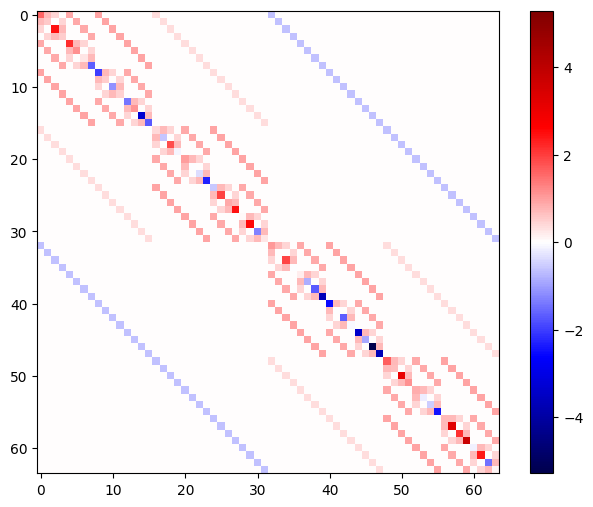

In [ ]:
# Use the ising_model function to generate more general ising models
def generate_random_ising(N, n, circular=True):
    n_tot = np.prod(n)
    if isinstance(n, int):
        n = (n,)
    J = np.random.uniform(-1, 1, size=(N, n_tot, n_tot))
    # make sure each J is symmetric
    for i in range(N):
        J[i] = (J[i] + J[i].T)/2
        # make sure the diagonal is zero
        J[i] -= np.diag(np.diag(J[i]))
    h = np.random.uniform(-1, 1, size=(N, n_tot))
    g = np.random.uniform(-1, 1, size=(N, n_tot))

    hamiltonians = []
    for i in range(N):
        H_ising_str = ising_model(n, J[i], h[i], g[i], kind=f'{len(n)}d', circular=circular)

        # create graph to find the indices of the edges
        grid = nk.graph.Grid(n, pbc=circular)
        edges = undirected_edges_from_graph(grid)
        J_i = np.zeros((n_tot, n_tot))
        J_i[edges] = J[i][edges]
    
        hamiltonians.append((H_ising_str, {"J": J_i, "h": h[i], "g": g[i]}))

    return hamiltonians

# This creates a hamiltonian like netket does, but using the ising_model function
def generate_random_ising_like_nk(N, n, circular=True):
    """ The main differences with generate_random_ising is (1) the coupling and field strengths are everywhere the same and (2) there is no longitudinal local field."""
    J = np.random.uniform(-1, 1, size=N)
    g = np.random.uniform(-1, 1, size=N)
    n_tot = np.prod(n)

    hamiltonians = []
    for i in range(N):
        H_ising_str = ising_model(n, J[i], 0, g[i], kind=f'{len(n)}d', circular=circular)

        # create graph to find the indices of the edges
        grid = nk.graph.Grid(n, pbc=circular)
        edges = undirected_edges_from_graph(grid)
        J_i = np.zeros((n_tot, n_tot))
        J_i[edges] = J[i]
        h_i = np.zeros(n_tot)
        g_i = g[i]*np.ones(n_tot)

        hamiltonians.append((H_ising_str, {"J": J_i, "h": h_i, "g": g_i}))

    return hamiltonians

# show a random hamiltonian
imshow(parse_hamiltonian(generate_random_ising(N=1, n=(2,3), circular=False)[0][0]).real)

## Check equivalence

In [ ]:
L = 3    # length of the lattice
n_dim = 2  # dimension of the lattice (1 = string, 2 = square, 3 = cube, ...)
J = np.random.uniform(-1, 1)
h = np.random.uniform(-1, 1)
circular = False

# check if the Hilbert space dimension is too large (happens too easily)
H_dim = 2**(L**n_dim)
mem_required = H_dim**2 *4
if mem_required > psutil.virtual_memory().available:
    raise ValueError(f"Warning: Large Hilbert space dimension {H_dim}! This would blow up your memory ({duh(mem_required)} bytes required)!")
elif H_dim > 2**11:
    print(f"Warning: Large Hilbert space dimension {H_dim}! This may take a while ({duh(mem_required)} bytes required)!")

# netket version of the Ising model
ising_nk = nk.operator.Ising(
    hilbert=nk.hilbert.Spin(s=0.5, N=L**n_dim),
    graph=nk.graph.Hypercube(length=L, n_dim=n_dim, pbc=circular),
    J=J, h=h
).to_dense()
# corresponds to the following special case
H_str = ising_model([L]*n_dim, J, 0, -h, circular=circular, kind=f"{n_dim}d")
ising_own = parse_hamiltonian(H_str).real

np.allclose(ising_nk, ising_own)

True

# Calculate ground state energies

## Exact diagonalization

In [ ]:
def diagonalize(hamiltonian, *args):
    if isinstance(hamiltonian, str):
        H = parse_hamiltonian(hamiltonian, sparse=True).real
    elif isinstance(hamiltonian, nk.operator.DiscreteOperator):
        H = hamiltonian.to_sparse()
    else:
        H = hamiltonian

    evals, evecs = sp.linalg.eigsh(H, k=1, which='SA')
    ground_state_energy = evals[0]
    ground_state = evecs[:,0]
    return ground_state_energy, ground_state

### **The actual generation is happening here!!!**

In [ ]:
def generate_exact(hamiltonians, data_path=None):
    """Generate the data set using exact diagonalization. This function does three things:
    1. Diagonalize the given Hamiltonians using exact diagonalization.
    2. Calculate the reduced density matrix of the ground state for each node and each edge in the fully connect graph.
    3. Save the data set to a file specified by data_path (optional).

    Previously generated data set can be extended by passing the path to the existing data set to data_path.
    If `data_path` is passed and data is found, but no Hamiltonians are given, the existing data set is returned.

    Parameters
        hamiltonians: list of 2-tuples, with Hamiltonians to be diagonalized (need to have all the same number dimension) and their hyperparameters
        data_path: path to save the data set

    Returns
        data: structured array containing the data set
    """
    if data_path is not None:
        # add .npy extension if not present
        if not data_path.endswith('.npy'):
            data_path += '.npy'
        if os.path.exists(data_path):
            # load existing data
            data_old = np.load(data_path, allow_pickle=True)
        else:
            os.makedirs(os.path.dirname(data_path), exist_ok=True)
            data_old = None
    if len(hamiltonians) == 0:
        if data_path is not None and data_old is not None:
            return data_old
        else:
            raise ValueError('No Hamiltonians given and no already generated data set found.')

    # get number of qubits
    n = get_n_qubits(hamiltonians[0][0])
    # create a structured array to store the data
    data = np.empty(len(hamiltonians), dtype=[
        ('hamiltonian', 'O'),                 # hamiltonian hyperparameters
        ('energy', 'f8'),                     # ground state energy
        # ('state', 'f8', (2**n,)),           # ground state (warning: blows up the data set size)
        ('node_rdm', 'f8', (n,2,2)),          # reduced density matrix for each node
        ('edge_rdm', 'f8', (n*(n-1)//2,4,4))  # reduced density matrix for each edge
    ])
    for i in tq(range(len(hamiltonians)), desc='Generating data set'):
        # get Hamiltonian
        hamiltonian, hyperparameters = hamiltonians[i]
        # get ground state energy and state
        energy, state = diagonalize(hamiltonian)
        # calculate reduced density matrix for each node and each edge
        node_rdms, edge_rdms = calculate_rdms(state, n)
        # add data to structured array
        # data[i] = (hyperparameters, energy, state, node_rdms, edge_rdms)
        data[i] = (hyperparameters, energy, node_rdms, edge_rdms)

    if data_path is not None:
        if data_old is not None:
            # merge old and new data
            data = np.concatenate([data_old, data])
            # remove duplicates
            # data = np.unique(data, axis=0)
        np.save(data_path, data)

    return data

Generating data set:   0%|          | 0/100 [00:00<?, ?it/s]

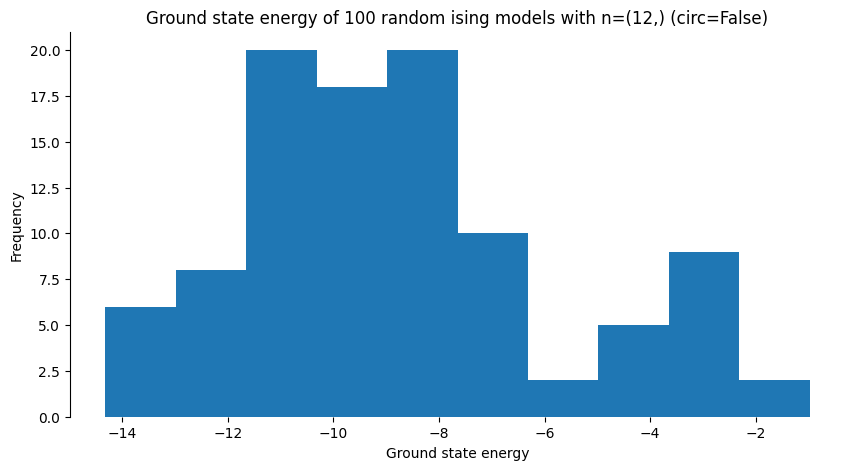

In [ ]:
clear_output()
n = (12,)  # System size
          # Timing for exact diagonalization (on M1 chip)
          # (8,) => 34000 / min, (12,) => 1400 / min, (16,) => 100 / min, (20,) => 4 / min
          # (2,4) => 36000 /min, (3,3) => 8000 / min, (3,4) => 1500 / min, (4,4) => 100 / min, (5,4) => 8 / min
          # (2,2,2) => 40000 / min, (2,2,3) => 1500 / min, (2,3,3) => 30 / min
circular = False # Whether to use periodic boundaries
N = 100          # Number of samples to generate

# Generate
data = generate_exact(generate_nk_ising(N, n, circular=circular), data_path=f'data/nk_{n}_{circular}')

# Plot
_ = hist(data['energy'], xlabel="Ground state energy", title=f"Ground state energy of {len(data)} random ising models with n={n} (circ={circular})")

Generating data set:   0%|          | 0/100 [00:00<?, ?it/s]

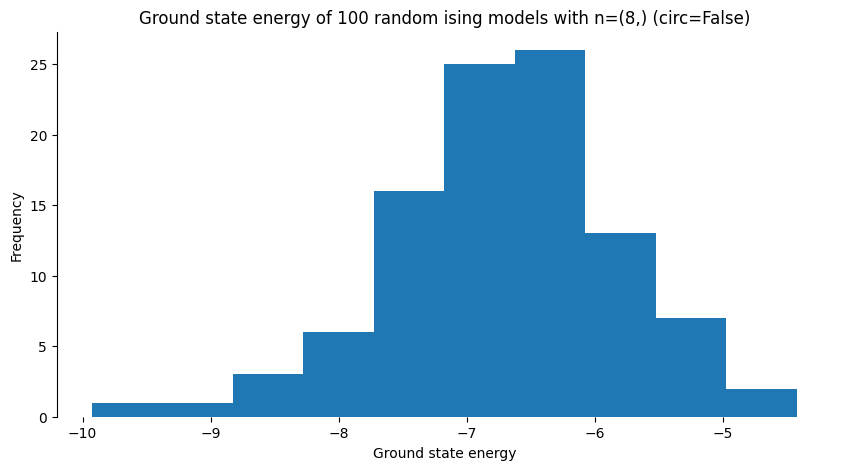

In [ ]:
clear_output()
n = (8,)  # System size
          # Timing for exact diagonlization (on M1 chip):
          # (8,) => 1400/min, (12,) => 12/min
          # (2,2) => 7400/min, (2,3) => 3200/min, (3,3) => 320/min, (3,4) => 10/min
          # (2,2,2) => 1100/min
circular = False  # Circular boundary
N = 100           # Number of samples to generate

# Generate
data = generate_exact(generate_random_ising(N, n, circular=circular), data_path=f'data/own_{n}_{circular}')

# Plot
_ = hist(data['energy'], xlabel="Ground state energy", title=f"Ground state energy of {len(data)} random ising models with n={n} (circ={circular})")

In [ ]:
sys.exit() # here to prevent the notebook from running further and destroying the plots when running all cells

SystemExit: 

In [ ]:
n = (8,)
# constructing the abstract representations of the hamiltonians
%timeit len(list(generate_nk_ising(N=100, n=n)))
%timeit len(list(generate_random_ising(N=100, n=n)))
# creating the actual matrices
%timeit len(list(h.to_sparse() for h, _ in generate_nk_ising(N=100, n=n)))
%timeit len(list(parse_hamiltonian(h, sparse=True) for h, _ in generate_random_ising(N=100, n=n)))
# look at the shapes
generate_nk_ising(N=1, n=n)[0][0].to_sparse().shape, parse_hamiltonian(generate_random_ising(N=1, n=n)[0][0]).shape

30.5 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
32.9 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.9 ms ± 730 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.21 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


((256, 256), (256, 256))

## Mean field ansatz

In [ ]:
import jax.numpy as jnp
import flax.linen as nn
import json

def save_data(specifier, cb=None):
    path = f"data/data_{specifier}.json"
    def _save(arg):
        if cb is not None:
            key, value = cb(arg)
        else:
            key, value = arg
        # append to json dict
        if os.path.exists(path):
            with open(path, "r") as f:
                data = json.load(f)
        else:
            data = {}
        data[key] = value
        with open(path, "w") as f:
            json.dump(data, f, indent=2)
    return _save

In [ ]:
class MF(nn.Module):

    @nn.compact
    def __call__(self, x):
        """
        Input: x.shape = (n_samples, L)
        Output: log_psi.shape = (n_samples,)
        """
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        p = nn.log_sigmoid(lam*x)
        return 0.5 * jnp.sum(p, axis=-1)
    
def mean_field(hamiltonian, n_samples=1000, n_iter=300, logfile='test', show_progress=False):
    vstate = nk.vqs.MCState(
        sampler=nk.sampler.MetropolisLocal(hamiltonian.hilbert),
        model=MF(),
        n_samples=n_samples,
    )
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate)
    gs.run(n_iter=n_iter, out=logfile, show_progress=show_progress)
    energy = vstate.expect(hamiltonian)
    # Check if converged
    if np.abs(energy.R_hat - 1) > 0.1:
        print('Not converged!', energy)
        return str(hamiltonian), np.nan

    return str(hamiltonian), float(energy.mean)

Ising(J=-0.8897347017710067, h=-0.4943595877530902; dim=12)


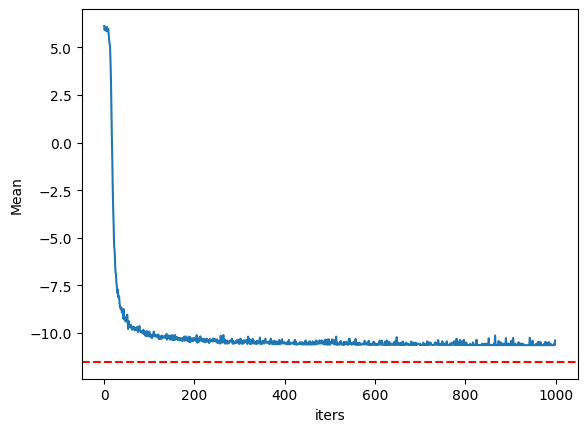

In [ ]:
clear_output()
def plot_json(filename, y, x, exact_energy):
    import json
    with open(filename) as f:
        data = json.load(f)
    data = data["Energy"]
    plt.plot(data[x], data[y])
    plt.axhline(exact_energy, color='r', linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

hamiltonian = generate_nk_ising(1, 12)[0][0]
print(hamiltonian)
mean_field(hamiltonian, n_samples=1000, n_iter=1000, logfile='test', show_progress=True)
# Also calculate exact energy
exact_energy = sp.linalg.eigsh(hamiltonian.to_sparse().astype(complex), k=1, which='SA')[0][0]
# Read JSON from "test.log" and plot "Energy.mean" against "Energy.iters"
plot_json('test.log', 'Mean', 'iters', exact_energy)

`n_iter == 300` seems like a good choice

## VMC (Jastrow)

In [ ]:
class Jastrow(nn.Module):

    @nn.compact
    def __call__(self, x):
        """
        Input: x.shape = (n_samples, L)
        Output: log_psi.shape = (n_samples,)
        """
        lam1 = self.param(
            "lambda1", nn.initializers.normal(), (1,), float
        )
        lam2 = self.param(
            "lambda2", nn.initializers.normal(), (1,), float
        )
        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(lam1*corr1+lam2*corr2,axis=-1)

def jastrow(hamiltonian, n_samples=1000, n_iter=30, logfile='test', show_progress=False):
    vstate = nk.vqs.MCState(
        sampler=nk.sampler.MetropolisLocal(hamiltonian.hilbert),
        model=Jastrow(),
        n_samples=n_samples,
    )
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate)
    gs.run(n_iter=n_iter, out=logfile, show_progress=show_progress)
    energy = vstate.expect(hamiltonian)
    # Check if converged
    if np.abs(energy.R_hat - 1) > 0.1:
        print('Not converged!', energy)
        return str(hamiltonian), np.nan

    return str(hamiltonian), float(energy.mean)

Ising(J=-0.10029482123926003, h=0.21623077672457747; dim=12)


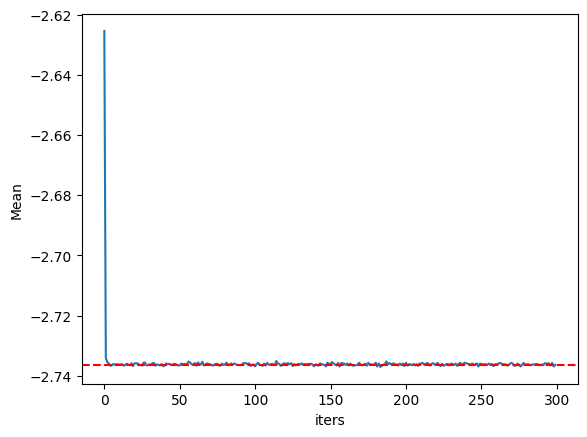

In [ ]:
clear_output()
def plot_json(filename, y, x, exact_energy):
    import json
    with open(filename) as f:
        data = json.load(f)
    data = data["Energy"]
    plt.plot(data[x], data[y])
    plt.axhline(exact_energy, color='r', linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

hamiltonian = generate_nk_ising(1, 12)[0][0]
print(hamiltonian)
jastrow(hamiltonian, n_samples=1000, n_iter=300, logfile='test', show_progress=True)
# Also calculate exact energy
exact_energy = sp.linalg.eigsh(hamiltonian.to_sparse().astype(complex), k=1, which='SA')[0][0]
# Read JSON from "test.log" and plot "Energy.mean" against "Energy.iters"
plot_json('test.log', 'Mean', 'iters', exact_energy)

If it converges, it usually takes `10-20` iterations.

## Grand comparison

In [ ]:
exact_energies = {}
mean_field_energies = {}
jastrow_energies = {}

  0%|          | 0/1000 [00:00<?, ?it/s]

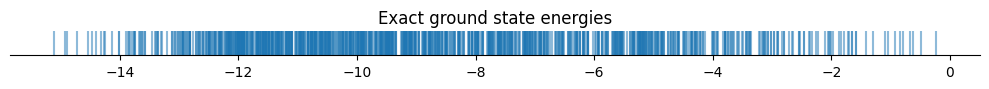

  0%|          | 0/100 [00:00<?, ?it/s]

Not converged! -5.937e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -1.163e+01 ± nan [σ²=0.000e+00, R̂=inf]


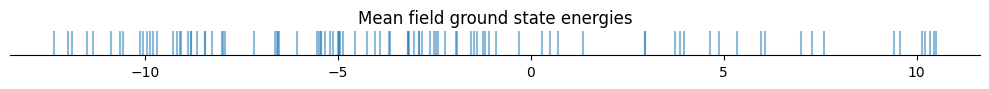

  0%|          | 0/1000 [00:00<?, ?it/s]

Not converged! -2.256e+00 ± 5.595e-17 [σ²=1.775e-30, R̂=1.1103]
Not converged! -9.198e+00 ± 1.119e-16 [σ²=3.155e-30, R̂=1.3757]
Not converged! -2.9097 ± 0.0029 [σ²=0.0085, R̂=1.1078]
Not converged! -1.020e+01 ± nan [σ²=2.840e-29, R̂=1.1546]
Not converged! -6.200e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -8.612 ± 0.014 [σ²=0.211, R̂=1.1057]
Not converged! -3.439e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -8.912 ± 0.015 [σ²=0.227, R̂=1.2374]
Not converged! -1.190e+01 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -1.085e+01 ± 0.000e+00 [σ²=2.840e-29, R̂=1.1564]
Not converged! -7.268 ± 0.029 [σ²=0.847, R̂=1.2071]
Not converged! -5.315e+00 ± 2.797e-17 [σ²=7.889e-31, R̂=1.1312]
Not converged! -0.659 ± 0.064 [σ²=4.183, R̂=1.2952]
Not converged! -8.611e+00 ± 3.357e-16 [σ²=2.840e-29, R̂=1.1093]
Not converged! -1.105e+01 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -1.147 ± 0.043 [σ²=1.863, R̂=1.2572]
Not converged! -9.416 ± 0.019 [σ²=0.369, R̂=1.1418]
Not converged! -4.965e+00 ± 1.958e-

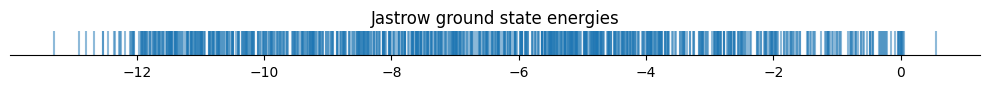

In [ ]:
clear_output()

N = 1000
L = 12
name = "12nk"
hamiltonians_test = generate_nk_ising(N, L)

if L <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test)
    scatter1d([e for e,s in exact_energies[name]], title='Exact ground state energies')

mean_field_energies[name] = mapp(mean_field, hamiltonians_test[::10], cb=save_data(f'mf_{L}'))
scatter1d([e for _,e in mean_field_energies[name]], title='Mean field ground state energies')

jastrow_energies[name] = mapp(jastrow, hamiltonians_test, cb=save_data(f'jastrow_{L}'))
scatter1d([e for _,e in jastrow_energies[name]], title='Jastrow ground state energies')

In [ ]:
sys.exit()

Below this are some generated figures that need quite some time to generate so I didn't want to remove them.

  0%|          | 0/20000 [00:00<?, ?it/s]

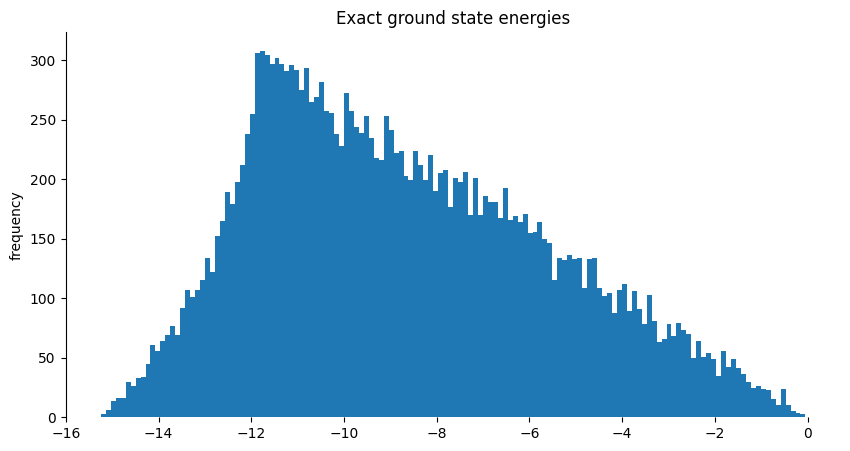

In [ ]:
clear_output()

N = 20000
L = 12
name = "12nk"
hamiltonians_test = generate_nk_ising(N, L)

if L <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test, cb=save_data(f'nk_{L}'))
    hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

  0%|          | 0/20000 [00:00<?, ?it/s]

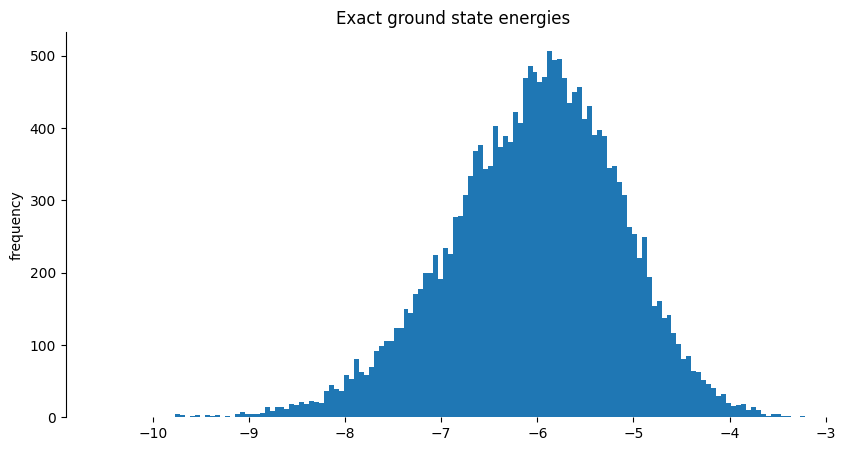

In [ ]:
clear_output()

N = 20000
n = (2,3)
name = "6is"
hamiltonians_test = generate_random_ising(N, n)

if np.prod(n) <= 23: # Max size with 16GB RAM
    exact_energies[name] = mapp(diagonalize, hamiltonians_test) # , cb=save_data(f'{n}')
    hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

  0%|          | 0/200 [00:00<?, ?it/s]

Not converged! -13.44 ± 0.14 [σ²=20.38, R̂=1.3764]
Not converged! -11.915 ± 0.074 [σ²=5.533, R̂=1.3953]
Not converged! -15.159 ± 0.021 [σ²=0.433, R̂=1.1848]
Not converged! -2.688 ± 0.070 [σ²=4.997, R̂=1.2376]
Not converged! -9.771e+00 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! -2.454e+01 ± 8.952e-16 [σ²=4.544e-28, R̂=1.1060]
Not converged! -2.456e+01 ± nan [σ²=0.000e+00, R̂=inf]
Not converged! 1.259 ± 0.078 [σ²=6.090, R̂=1.3115]
Not converged! -19.801 ± 0.025 [σ²=0.611, R̂=1.1616]
Not converged! -1.848e+01 ± 2.238e-16 [σ²=5.049e-29, R̂=1.1701]
Not converged! -1.756e+01 ± 4.476e-16 [σ²=5.049e-29, R̂=1.1020]
Not converged! -5.373e+00 ± 8.392e-17 [σ²=7.100e-30, R̂=1.1173]
Not converged! -2.155e+01 ± 6.714e-16 [σ²=2.019e-28, R̂=1.1423]
Not converged! -1.9265 ± 0.0027 [σ²=0.0074, R̂=1.1428]
Not converged! -16.901 ± 0.028 [σ²=0.814, R̂=1.4086]
Not converged! 5.280 ± 0.024 [σ²=0.600, R̂=1.1913]
Not converged! -0.096 ± 0.076 [σ²=5.877, R̂=1.3452]
Not converged! -1.044e+01 ± nan [σ²=3.155e-30,

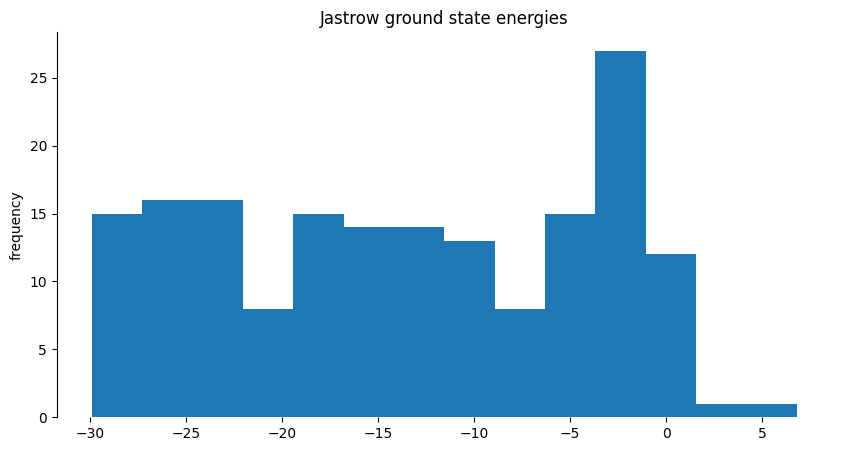

(array([15, 16, 16,  8, 15, 14, 14, 13,  8, 15, 27, 12,  1,  1]),
 array([-29.8924385 , -27.27141012, -24.65038174, -22.02935337,
        -19.40832499, -16.78729662, -14.16626824, -11.54523987,
         -8.92421149,  -6.30318312,  -3.68215474,  -1.06112636,
          1.55990201,   4.18093039,   6.80195876]))

In [ ]:
clear_output()

N = 200
L = 30
name = "30nk"
hamiltonians_test = generate_nk_ising(N, L)

jastrow_energies[name] = mapp(jastrow, hamiltonians_test, cb=save_data(f'jastrow_{L}'))
hist([e for e,s in jastrow_energies[name]], title='Jastrow ground state energies')

  0%|          | 0/2000 [00:00<?, ?it/s]

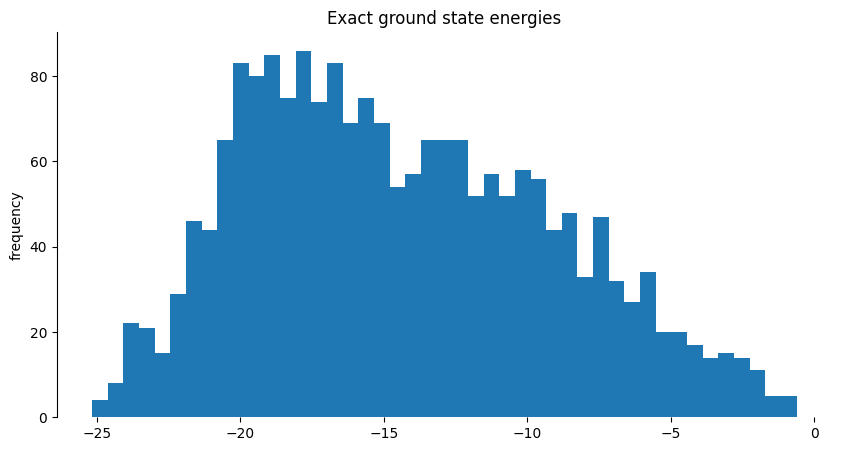

(array([ 4,  8, 22, 21, 15, 29, 46, 44, 65, 83, 80, 85, 75, 86, 74, 83, 69,
        75, 69, 54, 57, 65, 65, 65, 52, 57, 52, 58, 56, 44, 48, 33, 47, 32,
        27, 34, 20, 20, 17, 14, 15, 14, 11,  5,  5]),
 array([-25.16726518, -24.62169113, -24.07611708, -23.53054302,
        -22.98496897, -22.43939492, -21.89382086, -21.34824681,
        -20.80267276, -20.25709871, -19.71152465, -19.1659506 ,
        -18.62037655, -18.0748025 , -17.52922844, -16.98365439,
        -16.43808034, -15.89250628, -15.34693223, -14.80135818,
        -14.25578413, -13.71021007, -13.16463602, -12.61906197,
        -12.07348791, -11.52791386, -10.98233981, -10.43676576,
         -9.8911917 ,  -9.34561765,  -8.8000436 ,  -8.25446954,
         -7.70889549,  -7.16332144,  -6.61774739,  -6.07217333,
         -5.52659928,  -4.98102523,  -4.43545117,  -3.88987712,
         -3.34430307,  -2.79872902,  -2.25315496,  -1.70758091,
         -1.16200686,  -0.6164328 ]))

In [ ]:
clear_output()

N = 2000
L = 20
name = f"{L}nk"
hamiltonians_test = generate_nk_ising(N, L)

exact_energies[name] = mapp(diagonalize, hamiltonians_test, cb=save_data(f'nk_{L}'))
hist([e for e,s in exact_energies[name]], title='Exact ground state energies')

## Inspect generated data
(only for the old json format)

** 25649 entries **
-0.048	Ising(J=-0.0023830287088391078, h=-0.0036259028799132675; dim=12)
-0.067	Ising(J=-0.005372007939111079, h=-0.00199769177451925; dim=12)
-0.098	Ising(J=-0.00406869368904994, h=0.007618276772120236; dim=12)
-0.151	Ising(J=0.006803878281625764, h=0.011576980778128076; dim=12)
-0.162	Ising(J=0.007532350518863806, h=-0.012336536584942603; dim=12)
-0.171	Ising(J=-0.006998030814555634, h=-0.013288901364894912; dim=12)
-0.188	Ising(J=0.013791444166151079, h=-0.009916519386437894; dim=12)
-0.217	Ising(J=0.006394337019399288, h=-0.017488638099401932; dim=12)
-0.233	Ising(J=0.006455496170406194, h=-0.01883834643085458; dim=12)
-0.300	Ising(J=-0.024215757167517893, h=0.008527348382344035; dim=12)


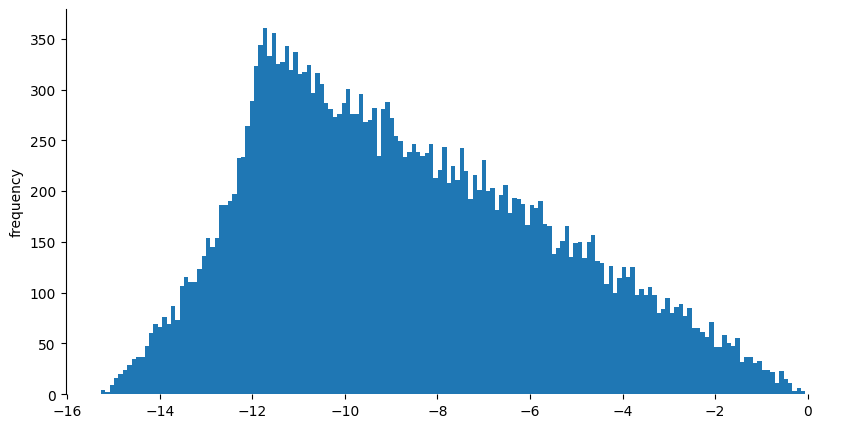

In [ ]:
# with open('data/data_jastrow_30.json', 'r') as f:
with open('data/data_nk_12.json', 'r') as f:
# with open('data/data_(2, 3).json', 'r') as f:
    data = json.load(f)
    # sort by energy
    data_s = sorted(data.items(), key=lambda x: x[1] if not np.isnan(x[1]) else -np.inf)
    print("**",len(data), "entries **")
    for H, E0 in data_s[::-1][:10]:
        print(f"{E0:>3.3f}\t{H}")
    hist(list(data.values()))